In [31]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import invgamma,t
from numpy import random, linalg
from scipy.stats import multivariate_normal
from scipy.stats import truncnorm

In [7]:

#Gibbs parameters
samples= 4000
Vt = 6

#s1,s2 -Assembler
s1_list=[]
s2_list=[]

#mean S assembler
s1_s2_mean_col=np.array([[20],[30]])
s1_mean_prior=20
s2_mean_prior=30

#dev S assembler
s_covar_matrix=np.array([[1,0],[0,1]])
s1_var_prior=1
s2_var_prior=1


#def A
A=np.array([[1,-1]])

# truncnorm parameters
a=0
b=np.inf



In [8]:
s1 = float(s1_s2_mean_col[0])
s2 = float(s1_s2_mean_col[1])
s1_var = s_covar_matrix[0][0]
s2_var = s_covar_matrix[1][1]
s_sampling_covarmatrix = s_covar_matrix


In [9]:
for i in range(samples):

        # Sample t from p(t|s1,s2,y)
        mean_t = (s1 - s2) # + boost_parameter # |--Q10 project extension = boost parameter--|
       
        t = truncnorm.rvs((a - mean_t) / np.sqrt(Vt), (b - mean_t) / np.sqrt(Vt), loc=mean_t, scale=np.sqrt(Vt), size=1)

        # Sample s1 and s2 from multivariate normal, p(s1,s2|t,y)
        s_old_var = s_sampling_covarmatrix
        s_sampling_covarmatrix = np.linalg.inv(np.linalg.inv(s_sampling_covarmatrix) + np.transpose(A) @A*(1/Vt))
        s1_s2_mean_col = s_sampling_covarmatrix @ (np.linalg.inv(s_old_var) @ s1_s2_mean_col + np.transpose(A) * (1/Vt) * t)
        s1, s2 = np.random.multivariate_normal(s1_s2_mean_col.flatten(), s_sampling_covarmatrix, 1).T 


        # Save values and lists
        s1_list.append(float(s1))
        s2_list.append(float(s2))

In [10]:
# Results
burn_in = 250

print(f'length of s1_list: {len(s1_list)}')
print(f'length of s2_list: {len(s2_list)}')

s1_burned_list = s1_list[burn_in:]
s2_burned_list = s2_list[burn_in:]
print(f'\nlength of s1_list after burn in: {len(s1_burned_list)}')
print(f'\nlength of s2_list after burn in: {len(s2_burned_list)}')

s1_mean = np.mean(s1_list)
s2_mean = np.mean(s2_list)
print(f'\nmean of s1: {s1_mean}')
print(f'mean of s2: {s2_mean}')

s1_burned_mean = np.mean(s1_burned_list)
s2_burned_mean = np.mean(s2_burned_list)
print(f'\nmean of s1 after burn in: {s1_burned_mean}')
print(f'mean of s2 after burn in: {s2_burned_mean}')

s1_var = np.var(s1_list)
s2_var = np.var(s2_list)
print(f'\nvariance of s1: {s1_var}')
print(f'variance of s2: {s2_var}')

s1_burned_var = np.var(s1_burned_list)
s2_burned_var = np.var(s2_burned_list)
print(f'\nvariance of s1 after burn in: {s1_burned_var}')
print(f'variance of s2 after burn in: {s2_burned_var}')


length of s1_list: 4000
length of s2_list: 4000

length of s1_list after burn in: 3750

length of s2_list after burn in: 3750

mean of s1: 26.647187406989723
mean of s2: 23.293872712771176

mean of s1 after burn in: 26.6988882838965
mean of s2 after burn in: 23.241177471271126

variance of s1: 0.5880481711610037
variance of s2: 0.5937217896856677

variance of s1 after burn in: 0.5230742090484272
variance of s2 after burn in: 0.5269250097305231


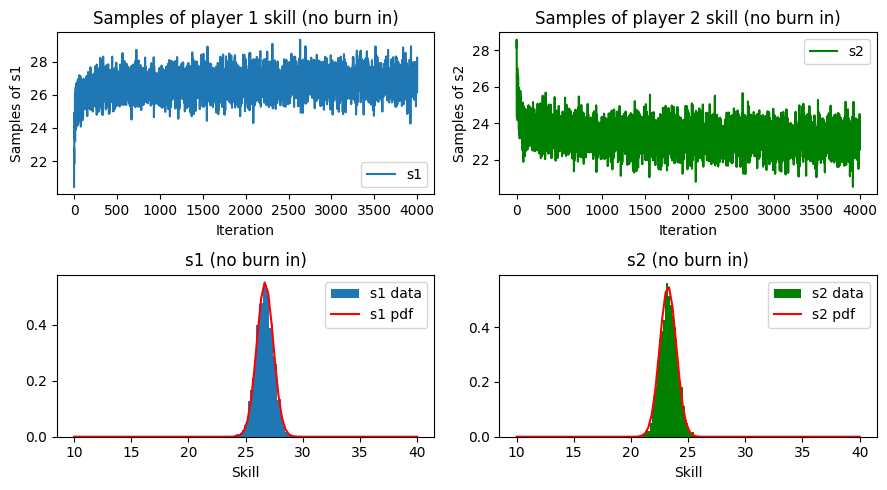

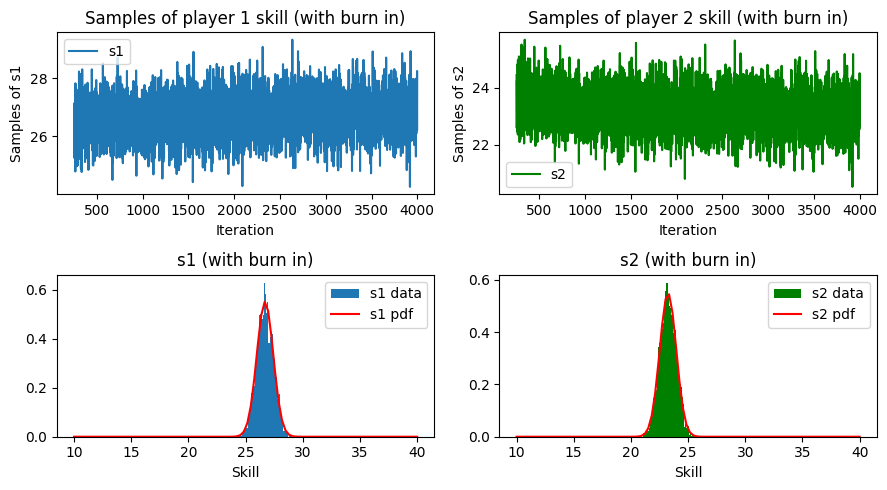

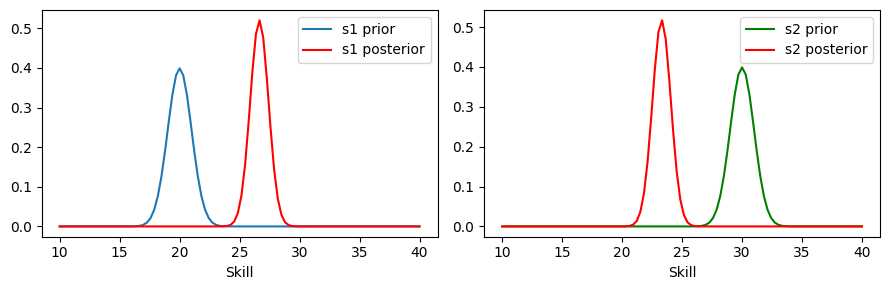

In [11]:
# Plotting
from scipy import stats

for i in range(2):

    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(9, 5))
    
    burn = 0 if i==0 else burn_in
    burn_title = '(no burn in)' if i==0 else '(with burn in)'

    # Player 1
    # Plot the mean of s1 (skill of player 1)
    axes[0, 0].plot(range(burn, samples), s1_list[burn:], label='s1') 
    axes[0, 0].set_title(f'Samples of player 1 skill {burn_title}')
    axes[0, 0].set_xlabel('Iteration')
    axes[0, 0].set_ylabel('Samples of s1')


    # Player 2
    # Plot the mean of s2 (skill of player 2)
    axes[0, 1].plot(range(burn, samples), s2_list[burn:], label='s2', color='g') 
    axes[0, 1].set_title(f'Samples of player 2 skill {burn_title}')
    axes[0, 1].set_xlabel('Iteration')
    axes[0, 1].set_ylabel('Samples of s2')


    # Create pdf for player s1 and player s2
    x_span = np.linspace(10, 40, 100) 
    
    axes[1, 0].hist(s1_list[burn:], bins=50, density=True, label=f's1 data')
    axes[1, 0].plot(x_span, stats.norm.pdf(x_span, s1_burned_mean, np.sqrt(s1_burned_var)), 'r', label=f's1 pdf')
    axes[1, 0].set_title(f's1 {burn_title}')
    axes[1, 0].set_xlabel('Skill')

    axes[1, 1].hist(s2_list[burn:], bins=50, density=True, color='g', label=f's2 data')
    axes[1, 1].plot(x_span, stats.norm.pdf(x_span, s2_burned_mean, np.sqrt(s2_burned_var)), 'r', label=f's2 pdf')
    axes[1, 1].set_title(f's2 {burn_title}')
    axes[1, 1].set_xlabel('Skill')

    for ax in axes.ravel():
        ax.legend()
    

    plt.tight_layout()
    plt.show()

# Plot prior p(s1) and p(s2) to compare with the posterior
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9, 3))
x_span = np.linspace(10, 40, 100)     ############# change this to fit the data

axes[0].plot(x_span, stats.norm.pdf(x_span, s1_mean_prior, np.sqrt(s1_var_prior)), label=f's1 prior') # prior s1
axes[0].plot(x_span, stats.norm.pdf(x_span, s1_mean, np.sqrt(s1_var)), 'r', label=f's1 posterior') # posterior s1
axes[1].plot(x_span, stats.norm.pdf(x_span, s2_mean_prior, np.sqrt(s2_var_prior)), 'g', label=f's2 prior') # prior s2
axes[1].plot(x_span, stats.norm.pdf(x_span, s2_mean, np.sqrt(s2_var)), 'r', label=f's2 posterior') # posterior s2

axes[0].set_xlabel('Skill')
axes[1].set_xlabel('Skill')
for ax in axes.ravel():
        ax.legend()
plt.tight_layout()
plt.show()
